# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [2]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

Using TensorFlow backend.


In [3]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

### Load and preprocess image

In [4]:
from keras.preprocessing import image

In [5]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

---

## RISE

In [6]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

In [7]:
batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal

---

## Running explanations

In [8]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [9]:
model = Model()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
img, x = load_img('catdog.png')

In [11]:
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:03<00:00, 515.37it/s]


In [12]:
sal = explain(model, x, masks)

Explaining: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


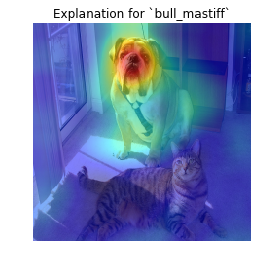

In [13]:
class_idx = 243
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()